In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.stats as stats
from statsmodels.miscmodels.ordinal_model import OrderedModel

# 1. Data Preprocessing

In [ ]:
data = pd.read_csv("shitrentals.csv")

In [ ]:
koi data.head()

,review_id,date,score,lessor,agency_name,property_type,weekly_price,n_bedrooms,suburb,review_text
0,1,2023-11-24 04:08:00,5,Agency,McGrath Estate Agents,Flat/Unit,400,2,Redfern,Living in this apartment was quite the ordeal....
1,2,2023-08-02 13:33:00,4,Agency,Ray White Group,Flat/Unit,300,2,Camperdown,Lease violations were a significant issue in t...
2,3,2023-08-03 02:08:00,3,Agency,Harcourts,Flat/Unit,290,2,Camperdown,Communication with the landlord was a nightmar...
3,4,2023-01-13 11:21:00,5,Agency,Harcourts,Flat/Unit,395,2,Redfern,"The property condition was disappointing, to s..."
4,5,2023-12-30 11:07:00,5,Agency,Century 21 Australia,Flat/Unit,395,2,Redfern,Pest problems and lease violations plagued my ...


In [ ]:
#Checking for missing values
missing_values = data.isnull().sum()
print("Missing values in each column")
print(missing_values)

Missing values in each column
review_id          0
date               0
score              0
lessor             0
agency_name      203
property_type      0
weekly_price       0
n_bedrooms         0
suburb             0
review_text        0
dtype: int64


In [ ]:
#Handling missing values
data['agency_name'].fillna('No agency involved', inplace= True)

**HANDLING MISSING VALUES IN AGENCY NAME**

* The agency name column contains 203 missing values.

* This was confirmed using multivariate non-graphical Exploratory Data Analysis (EDA) i.e. Cross Tabulation done below.

* These missing values correspond to instances where the lessor is a private individual rather than a rental agency.

* To address this, wefill the missing values with the placeholder "No agency involved" instead of dropping them to avoid introducing bias into the dataset.

In [ ]:
#Verifying the changes
print('Missing values in each column after handling')
missing_values_after_handling = data.isnull().sum()
print(missing_values_after_handling)

Missing values in each column after handling
review_id        0
date             0
score            0
lessor           0
agency_name      0
property_type    0
weekly_price     0
n_bedrooms       0
suburb           0
review_text      0
dtype: int64


* Using the data dictionary, the variables in our analysis can be categorized as follows:

   * Review ID: Categorical
   * Date: Categorical
   * Score: Numerical
   * Lessor: Categorical
   * Agency Name: Categorical
   * Property Type: Categorical
   * Weekly Price: Numerical
   * Number of Bedrooms: Categorical
   * Suburb: Categorical
   * Review Text: Unstructured Textual Data

In [ ]:
#Defining all the data variables to aid in our Exploratory Data Analysis (EDA) process
rid = data['review_id']
date = data['date']
s = data['score']
l = data['lessor']
an = data['agency_name']
pt = data['property_type']
wp = data['weekly_price']
nb = data['n_bedrooms']
sub = data['suburb']

**UNIVARIATE EXPLORATORY DATA ANALYSIS (EDA)**

**Non-Graphical Univariate EDA**

In [ ]:
#Review ID
rid.nunique()

1000

In [ ]:
#Date
date.nunique()

998

In [ ]:
date.describe()

count                    1000
unique                    998
top       2023-12-27 00:40:00
freq                        2
Name: date, dtype: object

In [ ]:
#Score
s.nunique()

5

In [ ]:
s.describe()

count    1000.000000
mean        2.955000
std         1.420913
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: score, dtype: float64

In [ ]:
#Lessor
l.value_counts()

Agency     797
Private    203
Name: lessor, dtype: int64

In [ ]:
#Agency Name
an.value_counts()

No agency involved                 203
Harcourts                           91
Century 21 Australia                86
RE/MAX Australia                    83
McGrath Estate Agents               82
Raine & Horne                       79
Ray White Group                     77
LJ Hooker                           76
First National Real Estate          75
Belle Property                      74
Professionals Real Estate Group     74
Name: agency_name, dtype: int64

In [ ]:
#Property Type
pt.value_counts()

Flat/Unit    1000
Name: property_type, dtype: int64

In [ ]:
#Weekly Price
wp.describe()

count    1000.000000
mean      267.215000
std        81.005127
min       110.000000
25%       200.000000
50%       280.000000
75%       305.000000
max       425.000000
Name: weekly_price, dtype: float64

In [ ]:
#Number of Bedrooms
nb.value_counts()

2    504
1    496
Name: n_bedrooms, dtype: int64

In [ ]:
#Suburb
sub.value_counts()

Camperdown    339
Redfern       332
Newtown       329
Name: suburb, dtype: int64

**Graphical Univariate EDA**

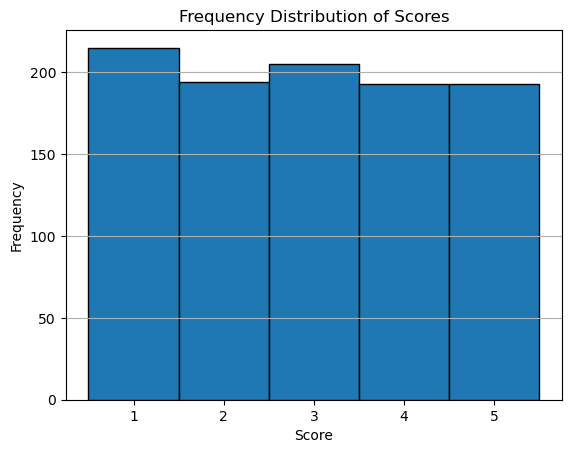

In [ ]:
#Analysing the frequency distribution of scores
plt.figure()
plt.hist(data['score'], bins=range(1, 7), edgecolor='black', align='left')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Scores')
plt.xticks(range(1, 6))
plt.grid(axis='y')
plt.savefig('Frequency Distribution of Scores.pdf')
plt.show()

* The frequency distribution of scores depicted in the histogram demonstrates that the scores are relatively evenly distributed across the scale from 1 to 5.

* This balanced distribution supports the justification for treating the score as an ordinal variable, as it reflects distinct, ordered categories with a meaningful ranking.

**EXCLUSION OF CERTAIN VARIABLES FROM THE ANALYSIS**

In our subsequent EDA and modelling, we have decided to not include the following variables - Review ID, Date and Property Type

Here are the reasons for their exclusion:

* Review ID - Serves as an unique identifer and does not contribute to prediction.

* Date - Lacks relevance to our analysis as there is no seasonal or temporal pattern expected in the review scores.

* Property Type - Only contains "unit/flat," offering little predictive power.

**MULTIVARIATE EXPLORATORY DATA ANALYSIS**

* In this section, we aim to explore the relationship between our target variable, the score, and other variables in the dataset. By employing graphical representations and statistical tests, we seek to identify significant feature variables that will be used in the modeling section.

* The code for plotting box plots to visualise the relationship between categorical and numerical variables has been taken from [link text](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html)

**Graphical Multivariate EDA**

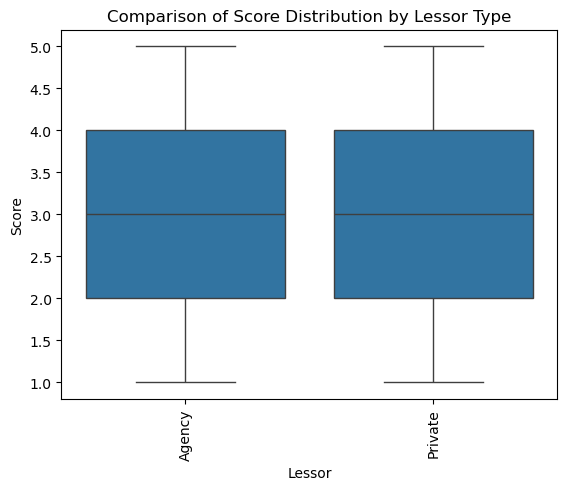

In [ ]:
#Analysing lessor and score
sns.boxplot(x='lessor', y='score', data=data)
plt.title('Comparison of Score Distribution by Lessor Type')
plt.xlabel('Lessor')
plt.ylabel('Score')
plt.xticks(rotation = 90)
plt.savefig('Lessor_and_Score.pdf')
plt.show()

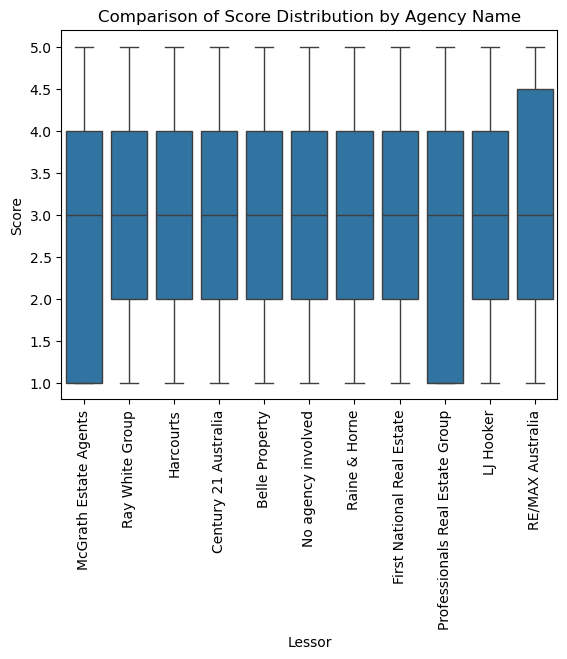

In [ ]:
#Analysing agency name and score
sns.boxplot(x='agency_name', y='score', data=data)
plt.title('Comparison of Score Distribution by Agency Name')
plt.xlabel('Lessor')
plt.ylabel('Score')
plt.xticks(rotation = 90)
plt.savefig('Agency_Name_and_Score.pdf')
plt.show()

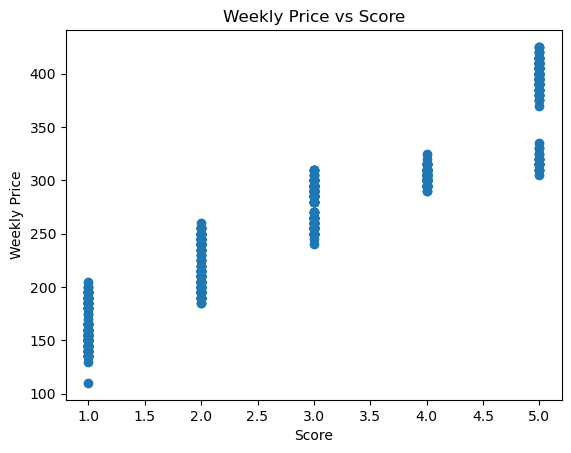

In [ ]:
#Analysing weekly price with score
plt.scatter( s, wp)
plt.xlabel('Score')
plt.ylabel('Weekly Price')
plt.title('Weekly Price vs Score')
plt.savefig('Weekly_Price_and_Score.pdf')
plt.show()

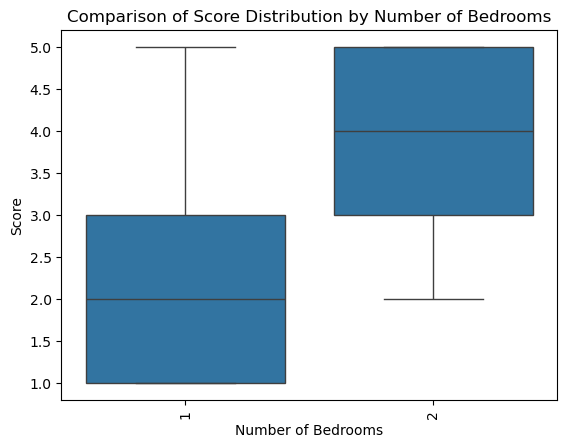

In [ ]:
#Analysing number of bedrooms and score
sns.boxplot(x='n_bedrooms', y='score', data=data)
plt.title('Comparison of Score Distribution by Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Score')
plt.xticks(rotation = 90)
plt.savefig('N_Bedrooms_and_Score.pdf')
plt.show()

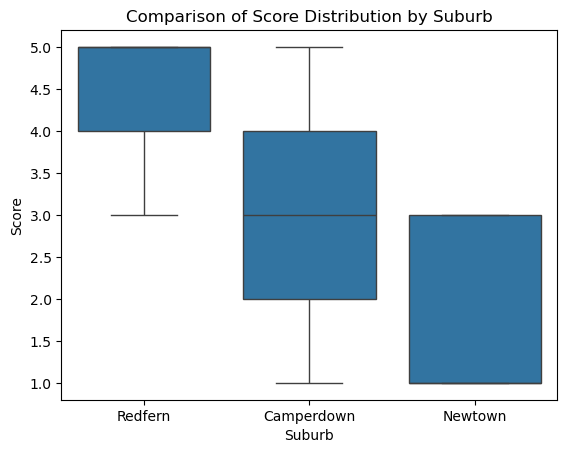

In [ ]:
#Analysing suburb and score
sns.boxplot(x='suburb', y='score', data=data)
plt.title('Comparison of Score Distribution by Suburb')
plt.xlabel('Suburb')
plt.ylabel('Score')
plt.savefig('Suburb_and_Score.pdf')
plt.show()

In [ ]:
#Correlation amongst numerical features- Score and Weekly Price
correlation = data [['score','weekly_price']].corr()
print(correlation)

                 score  weekly_price
score         1.000000      0.959895
weekly_price  0.959895      1.000000


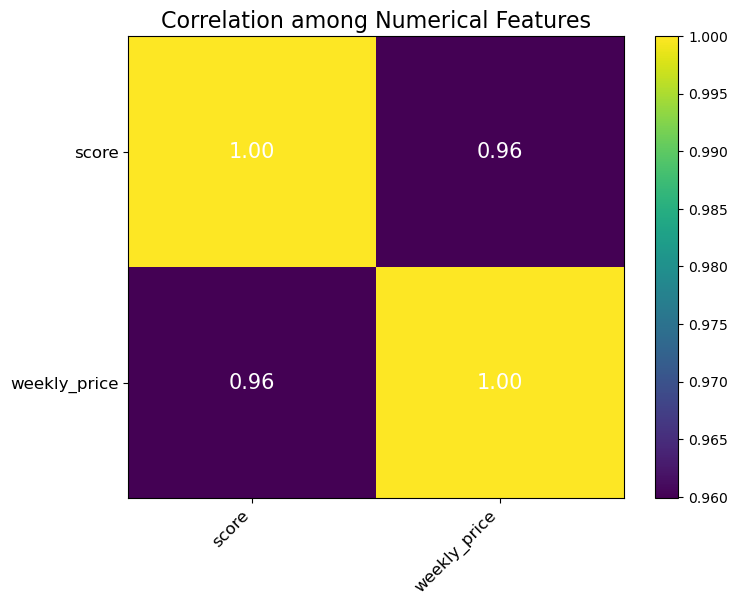

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(correlation, cmap='viridis', aspect='auto')
plt.colorbar()
n_var = len(correlation)
plt.xticks(range(n_var), correlation.columns, rotation=45, ha='right', fontsize=12)
plt.yticks(range(n_var), correlation.index, fontsize=12)
for i in range(n_var):
    for j in range(n_var):
        text_color = 'white' if correlation.iloc[i, j] > 0.5 else 'black'
        plt.text(i, j, f'{correlation.iloc[i, j]:.2f}', ha='center', va='center', color=text_color, fontsize=15)
plt.title('Correlation among Numerical Features', fontsize=16)
plt.savefig('Correlation_among_numerical_features.pdf', bbox_inches='tight')
plt.show()

* Graphical representations reveal a strong direct relationship between the score and weekly price, with a correlation coefficient of 0.96.

* For categorical variables, the number of bedrooms and suburb appear to influence the score, whereas there is no significant effect observed for lessor and agency name.

* The following section conducts statistical tests, specifically ANOVA, to identify the relationships between the score (numeric variable) and the categorical variables: number of bedrooms and suburb, using their respective p-values.

**NON-GRAPHICAL MULTIVARIATE EDA**

* The use of ANOVA to conduct statistical tests  extends from QBUS5001.

* The code has been generated using [link text](https://rinterested.github.io/statistics/p_values_regression_model_anova.html) with the help of a LLM platform to interpret the results.

In [ ]:
#Analysing number of bedrooms with score using ANOVA(P-Value)
score_n_bedrooms = ols('score~ C(n_bedrooms)', data=data).fit()
anova_score_n_bedrooms = sm.stats.anova_lm(score_n_bedrooms, typ=2)
print("ANOVA for Number of Bedrooms and Score")
(anova_score_n_bedrooms)

ANOVA for Number of Bedrooms and Score


,sum_sq,df,F,PR(>F)
C(n_bedrooms),658.347184,1.0,483.598585,1.037745e-87
Residual,1358.627816,998.0,NaN,NaN


In [ ]:
#Analysing suburb with score using ANOVA (P-Value)
score_suburb = ols('score~ C(suburb)', data=data).fit()
anova_score_suburb = sm.stats.anova_lm(score_suburb, typ=2)
print("ANOVA for Suburb and Score")
(anova_score_suburb)

ANOVA for Suburb and Score


,sum_sq,df,F,PR(>F)
C(suburb),1174.120545,2.0,694.424866,1.242961e-189
Residual,842.854455,997.0,NaN,NaN


* The p-value for the ANOVA tests is less than 0.05, indicating strong statistical significance and suggesting that the number of bedrooms and suburb have a significant effect on the score.

* Based on the exploratory data analysis (EDA) performed, we can conclude that our feature variables in the analysis include the number of bedrooms, suburb, and weekly price.

**EXPLORING THE POSSIBILITY OF INTERACTION TERMS**

* In this section we aim to study the possibility of existence of interaction terms between weekly price, number of bedrooms and suburb using multivariate graphical and statistical tests.

**GRAPHICAL EXPLORATION**

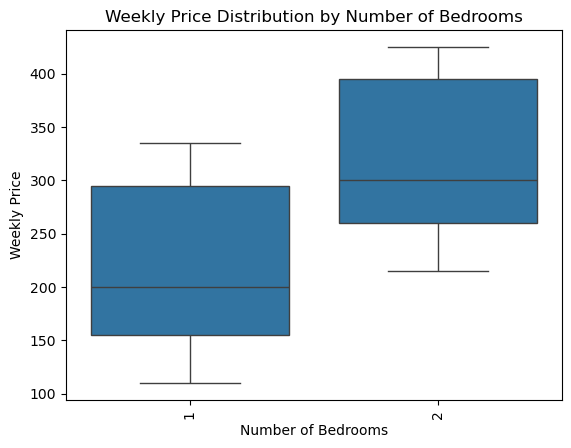

In [ ]:
#Analysing weekly price with number of bedrooms
sns.boxplot(x='n_bedrooms', y='weekly_price', data=data)
plt.title('Weekly Price Distribution by Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Weekly Price')
plt.xticks(rotation=90)
plt.show()

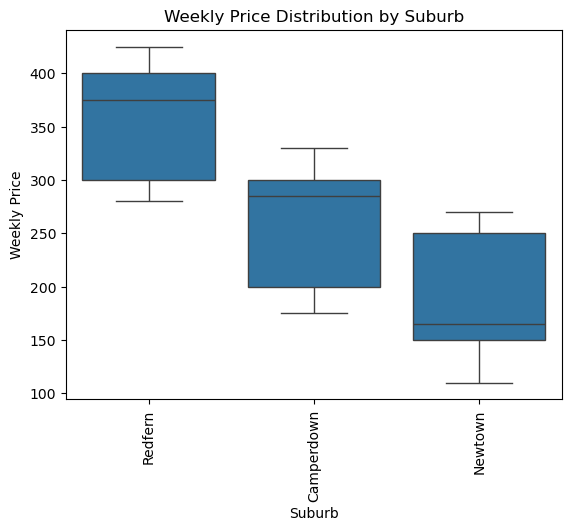

In [ ]:
#Analysing weekly price and suburb
sns.boxplot(x='suburb', y='weekly_price', data=data)
plt.title('Weekly Price Distribution by Suburb')
plt.xlabel('Suburb')
plt.ylabel('Weekly Price')
plt.xticks(rotation=90)
plt.savefig('Suburb and Weekly Price.pdf')
plt.show()

In [ ]:
#Analysing number of bedrooms and suburb
crosstab_3 = pd.crosstab(nb,sub)
crosstab_3

suburb,Camperdown,Newtown,Redfern
n_bedrooms,,,
1,164,169,163
2,175,160,169


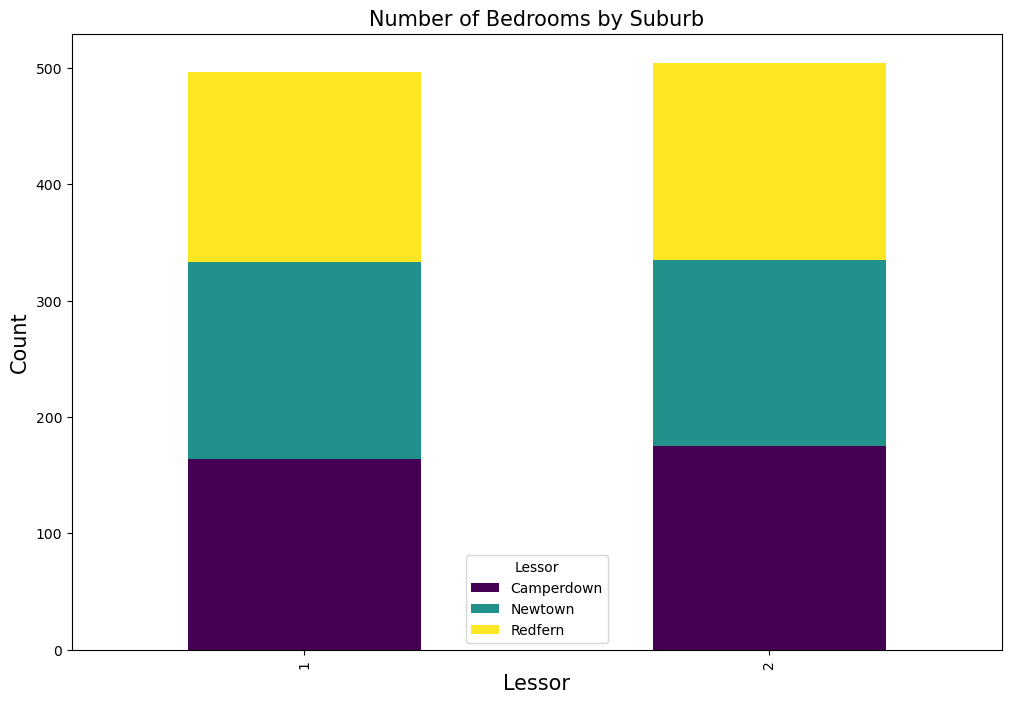

In [ ]:
#Visually analysing number of bedrooms and suburb
crosstab_3.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 8))
plt.title('Number of Bedrooms by Suburb', fontsize = 15)
plt.xlabel('Lessor', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.xticks(rotation=90, fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(title='Lessor')
plt.savefig('Number of Bedrooms and Suburb.pdf')
plt.show()

* Graphical exploration of the identified feature variables amongst themselves shows relationship amongst weekly price and number of bedrooms and weekly price and the area of suburb.

* In the following section we will use statistical tests to quantify the level of interaction amongst these feature variables using ANOVA P-Value statistical tests.

**STATISTICAL EXPLORATION**

In [ ]:
#Analysing suburb and weekly price using ANOVA(P-Value)
model_suburb = ols('weekly_price ~ C(suburb)', data=data).fit()
anova_table_suburb = sm.stats.anova_lm(model_suburb, typ=2)
print("ANOVA for Suburb and Weekly Price")
(anova_table_suburb)

ANOVA for Suburb and Weekly Price


,sum_sq,df,F,PR(>F)
C(suburb),3.944921e+06,2.0,753.364318,4.505977e-200
Residual,2.610348e+06,997.0,NaN,NaN


In [ ]:
#Analysing number of bedrooms and weekly price using ANOVA(P-Value)
model_n_bedrooms = ols('weekly_price ~ C(n_bedrooms)', data=data).fit()
anova_table_n_bedrooms = sm.stats.anova_lm(model_n_bedrooms, typ=2)
print("ANOVA for Number of Bedrooms and Weekly Price")
(anova_table_n_bedrooms)

ANOVA for Number of Bedrooms and Weekly Price


,sum_sq,df,F,PR(>F)
C(n_bedrooms),2.608034e+06,1.0,659.402869,4.712755e-112
Residual,3.947235e+06,998.0,NaN,NaN


* The p-value for the ANOVA tests is less than 0.05, indicating strong statistical significance and suggesting that the number of bedrooms and suburb have a significant affect on weekly prices.

* Based on the exploratory data analysis (EDA) performed, we can conclude that our feature variables in the analysis can also include interaction terms between weekly price and number of bedrooms and weekly price and suburb.

**The feature variables that will be used in our model building process are weekly price, number of bedrooms, suburb, interaction term between weekly price and suburb and interaction term between weekly price and number of bedrooms**

**GRAPHICAL JUSTIFICATION FOR HANDLING MISSING VALUES**

In [ ]:
#Analysing Lessor and Agency Name
#Using multivariate non-graphical EDA cross-tabulation
crosstab = pd.crosstab(l, an)
crosstab

agency_name,Belle Property,Century 21 Australia,First National Real Estate,Harcourts,LJ Hooker,McGrath Estate Agents,No agency involved,Professionals Real Estate Group,RE/MAX Australia,Raine & Horne,Ray White Group
lessor,,,,,,,,,,,
Agency,74,86,75,91,76,82,0,74,83,79,77
Private,0,0,0,0,0,0,203,0,0,0,0


**ONE-HOT ENCODING FOR CATEGORICAL DATA**

In [ ]:
#One-Hot Encoding for Categorical Variables
#Our Categorical Variables include lessor, agency_name, n_bedrooms and suburb
#We are only encoding n_bedrooms and suburb as they have an effect on score and will be used in the modelling section
#n_bedrooms is a categorical variable but is present in numerical terms. Defining it as a categorical variable to one-hot encode number of bedrooms
data['n_bedrooms'] = data['n_bedrooms'].astype('category')
encoded_data = pd.get_dummies(data[['n_bedrooms','suburb']], drop_first ='True')

In [ ]:
data = data.drop(columns=['n_bedrooms', 'suburb'])
#Concatenating it into our original dataset named data
data = pd.concat([data, encoded_data], axis= 1)
data.head(1)

,review_id,date,score,lessor,agency_name,property_type,weekly_price,review_text,n_bedrooms_2,suburb_Newtown,suburb_Redfern
0,1,2023-11-24 04:08:00,5,Agency,McGrath Estate Agents,Flat/Unit,400,Living in this apartment was quite the ordeal....,1,0,1


**FEATURE ENGINEERING FOR TEXTUAL DATA**

* The common themes identified amongst the review text include - pest infectations, lease violations and landlord issues.

* Based on these themes, the features used in our feature engineering are - pest, lease and landlord.

In [ ]:
#Feature Engineering for Review_Text
corpus = data['review_text'].to_numpy()
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(corpus)
tfidf = tfidf_vectorizer.transform(corpus)
feature_names = tfidf_vectorizer.get_feature_names_out()
words_of_interest = ['pest', 'violation', 'landlord']
word_indices = [feature_names.tolist().index(word) for word in words_of_interest]
tfidf_scores = tfidf[:, word_indices].toarray()
tfidf_df = pd.DataFrame(tfidf_scores, columns=words_of_interest)
tfidf_df

,pest,violation,landlord
0,0.065234,0.0,0.000000
1,0.000000,0.0,0.104131
2,0.070929,0.0,0.076209
3,0.000000,0.0,0.000000
4,0.100888,0.0,0.108398
...,...,...,...
995,0.000000,0.0,0.000000
996,0.000000,0.0,0.000000
997,0.000000,0.0,0.000000
998,0.000000,0.0,0.000000


In [ ]:
data = pd.concat([data, tfidf_df], axis= 1)
data.head(1)

,review_id,date,score,lessor,agency_name,property_type,weekly_price,review_text,n_bedrooms_2,suburb_Newtown,suburb_Redfern,pest,violation,landlord
0,1,2023-11-24 04:08:00,5,Agency,McGrath Estate Agents,Flat/Unit,400,Living in this apartment was quite the ordeal....,1,0,1,0.065234,0.0,0.0


**EDA OF REVIEW TEXT METRICS WITH SCORE**


In [ ]:
#Correlation analysis of text metrics with score
correlation_1 = data [['score','pest','landlord','violation']].corr()
print(correlation_1)

              score      pest  landlord  violation
score      1.000000 -0.001512  0.025044   0.017179
pest      -0.001512  1.000000  0.154956  -0.034564
landlord   0.025044  0.154956  1.000000  -0.031109
violation  0.017179 -0.034564 -0.031109   1.000000


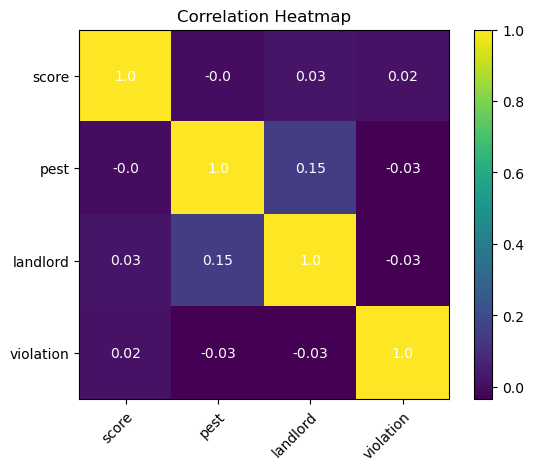

In [ ]:
#Visualising text metrics with score
fig, ax = plt.subplots()
cax = ax.imshow(correlation_1, cmap='viridis', interpolation='nearest')

# Adding colorbar
cbar = fig.colorbar(cax)

# Setting the ticks and labels
ax.set_xticks(np.arange(len(correlation_1.columns)))
ax.set_yticks(np.arange(len(correlation_1.index)))
ax.set_xticklabels(correlation_1.columns)
ax.set_yticklabels(correlation_1.index)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(len(correlation_1.index)):
    for j in range(len(correlation_1.columns)):
        text = ax.text(j, i, round(correlation_1.iloc[i, j], 2),
                       ha="center", va="center", color="w")

# Display the heatmap
plt.title('Correlation Heatmap')
plt.show()

* From the graphical representation of the text metrics wirh score, none of the features identified amongst the main themes have a correlation with score.

* Due to the nature of its low correlation coefficients with the target variable, score we do not intend to add this in our Generalised Linear Model.

# 2. Modelling

In this study, four models were created to understand the understand the best suitable model to predict tenant satisfaction scores:
* Model 1: Weekly Price, Number of Bedrooms, and Suburb.
* Model 2: Weekly Price with Interaction Terms (Weekly Price * Number of Bedrooms and Weekly Price * Suburb).
* Model 3: Weekly Price and Interaction Term (Weekly Price * Number of Bedrooms).
* Model 4: Weekly Price and Interaction Term (Weekly Price * Suburb).

**MODEL 1**

In [ ]:
X1 = data[['weekly_price','n_bedrooms_2','suburb_Newtown','suburb_Redfern']]
Y1 = data['score']
mod_log = OrderedModel(Y1, X1, distr='logit')
res_log = mod_log.fit(method='bfgs', disp=False)
res_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  score   Log-Likelihood:                -267.10
Model:                   OrderedModel   AIC:                             550.2
Method:            Maximum Likelihood   BIC:                             589.5
Date:                Tue, 28 May 2024                                         
Time:                        06:30:34                                         
No. Observations:                1000                                         
Df Residuals:                     992                                         
Df Model:                           4                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
weekly_price       0.3026      0.022     13.813      0.000       0.260       0.345
n_bedrooms_2      40.0286    323.947      0.124      0.902    -594.896     674.954
suburb_Newtown   -28.0687    260.768     -0.108      0.914    -539.165     483.028
suburb_Redfern    40.3291    323.948      0.124      0.901    -594.597     675.255
1/2               58.0286      4.238     13.691      0.000      49.722      66.336
2/3                3.3897      6.479      0.523      0.601      -9.308      16.088
3/4                3.7403      6.193      0.604      0.546      -8.397      15.878
4/5                1.8279      0.073     24.900      0.000       1.684       1.972
==================================================================================
"""

**MODEL 2**

In [ ]:
#Creating interaction terms between weekly_price and number of bedrooms
data['interaction_weekly_price_n_bedrooms'] = data['weekly_price'] * data['n_bedrooms_2']
data.head(1)

,review_id,date,score,lessor,agency_name,property_type,weekly_price,review_text,n_bedrooms_2,suburb_Newtown,suburb_Redfern,pest,violation,landlord,interaction_weekly_price_n_bedrooms
0,1,2023-11-24 04:08:00,5,Agency,McGrath Estate Agents,Flat/Unit,400,Living in this apartment was quite the ordeal....,1,0,1,0.065234,0.0,0.0,400


In [ ]:
#Creating interaction terms for weekly_price and suburbs
suburb_columns = ['suburb_Newtown','suburb_Redfern']
for suburb in suburb_columns:
    interaction_weekly_price_suburb = f'interaction_weekly_price_{suburb}'
    data[interaction_weekly_price_suburb] = data['weekly_price'] * data[suburb]
data.head(1)

,review_id,date,score,lessor,agency_name,property_type,weekly_price,review_text,n_bedrooms_2,suburb_Newtown,suburb_Redfern,pest,violation,landlord,interaction_weekly_price_n_bedrooms,interaction_weekly_price_suburb_Newtown,interaction_weekly_price_suburb_Redfern
0,1,2023-11-24 04:08:00,5,Agency,McGrath Estate Agents,Flat/Unit,400,Living in this apartment was quite the ordeal....,1,0,1,0.065234,0.0,0.0,400,0,400


In [ ]:
#Defining our x and y variables for our logit ordinal regression model with interaction terms
X2 = data[['weekly_price','interaction_weekly_price_n_bedrooms', 'interaction_weekly_price_suburb_Newtown', 'interaction_weekly_price_suburb_Redfern']]
Y2 = data['score']

In [ ]:
#Building our logit regression model
mod_log_1 = OrderedModel(Y2, X2, distr='logit')
res_log_1 = mod_log_1.fit(method='bfgs', disp=False)
res_log_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  score   Log-Likelihood:                -266.35
Model:                   OrderedModel   AIC:                             548.7
Method:            Maximum Likelihood   BIC:                             588.0
Date:                Tue, 28 May 2024                                         
Time:                        06:30:35                                         
No. Observations:                1000                                         
Df Residuals:                     992                                         
Df Model:                           4                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
weekly_price                                0.2556      0.042      6.146      0.000       0.174       0.337
interaction_weekly_price_n_bedrooms         0.0607      0.050      1.221      0.222      -0.037       0.158
interaction_weekly_price_suburb_Newtown     0.0026      0.020      0.135      0.893      -0.036       0.041
interaction_weekly_price_suburb_Redfern     0.0617      0.050      1.241      0.215      -0.036       0.159
1/2                                        48.9577      8.042      6.087      0.000      33.195      64.721
2/3                                         3.4299      0.335     10.249      0.000       2.774       4.086
3/4                                         2.6405      0.373      7.074      0.000       1.909       3.372
4/5                                         1.8605      0.079     23.652      0.000       1.706       2.015
===========================================================================================================
"""

**MODEL 3**

In [ ]:
#Building an ordinal regression model with only weekly_price and weekly price interaction with n bedrooms
X3 = data[['weekly_price','interaction_weekly_price_n_bedrooms']]
Y3 = data['score']
mod_log_2 = OrderedModel(Y3, X3, distr='logit')
res_log_2 = mod_log_2.fit(method='bfgs', disp=False)
res_log_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  score   Log-Likelihood:                -267.14
Model:                   OrderedModel   AIC:                             546.3
Method:            Maximum Likelihood   BIC:                             575.7
Date:                Tue, 28 May 2024                                         
Time:                        06:30:35                                         
No. Observations:                1000                                         
Df Residuals:                     994                                         
Df Model:                           2                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
weekly_price                            0.3033      0.022     13.878      0.000       0.260       0.346
interaction_weekly_price_n_bedrooms    -0.0010      0.001     -1.033      0.302      -0.003       0.001
1/2                                    58.1764      4.229     13.757      0.000      49.888      66.465
2/3                                     2.8619      0.076     37.865      0.000       2.714       3.010
3/4                                     2.6410      0.076     34.859      0.000       2.493       2.789
4/5                                     1.8285      0.073     24.945      0.000       1.685       1.972
=======================================================================================================
"""

**MODEL 4**

In [ ]:
X4 = data[['weekly_price','interaction_weekly_price_suburb_Newtown','interaction_weekly_price_suburb_Redfern']]
Y4 = data[['score']]
mod_log_3 = OrderedModel(Y4, X4, distr='logit')
res_log_3 = mod_log_3.fit(method='bfgs', disp=False)
res_log_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  score   Log-Likelihood:                -267.05
Model:                   OrderedModel   AIC:                             548.1
Method:            Maximum Likelihood   BIC:                             582.5
Date:                Tue, 28 May 2024                                         
Time:                        06:30:35                                         
No. Observations:                1000                                         
Df Residuals:                     993                                         
Df Model:                           3                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
weekly_price                                0.3019      0.022     13.925      0.000       0.259       0.344
interaction_weekly_price_suburb_Newtown     0.0069      0.015      0.451      0.652      -0.023       0.037
interaction_weekly_price_suburb_Redfern     0.0010      0.001      1.059      0.290      -0.001       0.003
1/2                                        57.8957      4.193     13.807      0.000      49.677      66.114
2/3                                         2.9638      0.208     14.252      0.000       2.556       3.371
3/4                                         2.5088      0.320      7.831      0.000       1.881       3.137
4/5                                         1.8275      0.073     24.987      0.000       1.684       1.971
===========================================================================================================
"""

## 2.1 Model Selection

**MODEL METRICS FOR MODEL 1**

In [ ]:
category_counts = Y1.value_counts().sort_index()
category_probs = category_counts / len(Y1)

ll_null = np.sum(category_counts * np.log(category_probs))

ll_full = res_log.llf

pseudo_r_squared = 1 - (ll_full / ll_null)
print("McFadden's Pseudo R-squared:", pseudo_r_squared)

McFadden's Pseudo R-squared: 0.8339435980066207


**MODEL METRICS FOR MODEL 2**

In [ ]:
category_counts_1 = Y2.value_counts().sort_index()
category_probs_1 = category_counts_1 / len(Y2)

ll_null_1 = np.sum(category_counts_1 * np.log(category_probs_1))

ll_full_1 = res_log_1.llf

pseudo_r_squared_1 = 1 - (ll_full_1 / ll_null_1)
print("McFadden's Pseudo R-squared:", pseudo_r_squared_1)

McFadden's Pseudo R-squared: 0.8344099115499233


**MODEL METRICS FOR MODEL 3**

In [ ]:
category_counts_2 = Y3.value_counts().sort_index()
category_probs_2 = category_counts_2 / len(Y3)

ll_null_2 = np.sum(category_counts_2 * np.log(category_probs_2))

ll_full_2 = res_log_2.llf

pseudo_r_squared_2 = 1 - (ll_full_2 / ll_null_2)
print("McFadden's Pseudo R-squared:", pseudo_r_squared_2)

McFadden's Pseudo R-squared: 0.83391636840448


**MODEL METRICS FOR MODEL 4**

In [ ]:
category_counts_3 = Y4.value_counts().sort_index()
category_probs_3 = category_counts_3 / len(Y4)

ll_null_3 = np.sum(category_counts_3 * np.log(category_probs_3))

ll_full_3 = res_log_3.llf

pseudo_r_squared_3 = 1 - (ll_full_3 / ll_null_3)
print("McFadden's Pseudo R-squared:", pseudo_r_squared_3)

McFadden's Pseudo R-squared: 0.833973831403042


**OPTIMAL MODEL SELECTION**

* Based on the metrics, Model 3 with feature variables as weekly price and interaction term between weekly price and number of bedrooms is the best model amongst the compared models.

* Model 3 has a log-likelihood of -267.14, which is slightly lower than that of Model 2. However, Model 3 has the lowest AIC (546.3) and BIC (575.7), indicating it provides the best balance between goodness of fit and model complexity.

* All models have the same McFadden’s Pseudo R² (0.83), meaning they explain the same proportion of variance. Given these considerations, Model 3 is the optimal choice due to its lowest AIC and BIC values.